In [6]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn
import torch
import torchsummary
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import pickle
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [14]:

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
(1288, 1850)


[[0.5006536  0.53333336 0.5372549  ... 0.8705883  0.8928105  0.88366014]
 [0.6535948  0.55947715 0.49019608 ... 0.12418301 0.1503268  0.16470589]
 [0.45751634 0.45882353 0.46797386 ... 0.12156863 0.11764706 0.10980392]
 ...
 [0.48496735 0.45228758 0.45620918 ... 0.39869285 0.39084968 0.52679735]
 [0.43398693 0.44575164 0.6052287  ... 0.20653595 0.19215687 0.22222222]
 [0.04444445 0.05490196 0.06143792 ... 0.64836603 0.71503264 0.83267975]]
(966, 1850)
(322, 1850)
X_train shape: (966, 1, 50, 37)


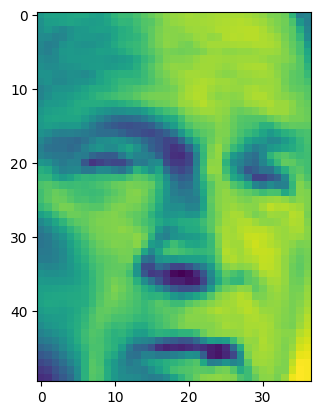

In [33]:
# from torch.nn import module
import torch
import cv2

# Split into a training set and a test set using a stratified k fold
x_tr, x_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25, random_state=42)# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# x_tr, x_ts, y_tr, y_ts = torch.from_numpy(x_tr), torch.from_numpy(x_ts), torch.from_numpy(y_tr), torch.from_numpy(y_ts)
print(x_tr)
#normalise
x_tr = x_tr / 255.0
x_ts = x_ts / 255.0
print(x_tr.shape)
print(x_ts.shape)
x_tr = x_tr.reshape(-1, 1, h, w)
x_ts = x_ts.reshape(-1, 1, h, w)

print("X_train shape:", x_tr.shape)
plt.imshow(x_tr[0, 0])

In [ ]:
class CiFAR10Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x.clone()
        self.y = y.clone()
        
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim

class NutrientMLP(nn.Module):
    def __init__(self, n_feat, n_out, n_nodes):
        '''
        Initialize neural network parameters.
        
        Parameters
        ----------
        init: either 'zero' (all parameters are 0) or 'rand' (each parameter is uniformly sampled from [-0.5, 0.5])
        '''
        super().__init__()
        
        torch.manual_seed(0)
        
        self.n_feat = n_feat
        self.n_out = n_out
        self.n_nodes = n_nodes
        self.layers = OrderedDict()
        
        for i in range(len(n_nodes)):
            linear_name = 'linear'+str(i)
            if i == 0:
                w = nn.Parameter(torch.rand(n_nodes[i], n_feat))
                b = nn.Parameter(torch.rand(n_nodes[i]))
                self.layers[linear_name] = nn.Linear(n_feat, n_nodes[i])
            elif i == len(n_nodes)-1:
                w = nn.Parameter(torch.rand(n_out, n_nodes[i-1]))
                b = nn.Parameter(torch.rand(n_out))
                self.layers[linear_name] = nn.Linear(n_nodes[i-1], n_out)
            else:
                w = nn.Parameter(torch.rand(n_nodes[i], n_nodes[i-1]))
                b = nn.Parameter(torch.rand(n_nodes[i]))
                self.layers[linear_name] = nn.Linear(n_nodes[i-1], n_nodes[i])
            self.layers[linear_name].weight = w
            self.layers[linear_name].bias = b
            self.layers['relu'+str(i)] = nn.ReLU()
            
        self.sequential = nn.Sequential(self.layers)
    
    def forward(self, x):
        # Task: add your forward computation code below
        out = self.sequential(x).view(-1)
        return out
    
    def predict(self, x):
        o = self(x)
        return l

In [ ]:
def mseloss(o, y):
    loss = nn.MSELoss()
    return loss(o, y)

In [ ]:
from torch.utils.data import DataLoader, Dataset
from time import time
from tqdm import tqdm

def train(net, x, y, x_ts, y_ts, lossfunc, lr=0.1, momentum=0.1, opt="SGD", batch_size=600, nepochs=10, clip=10, loop_prepend=""):
    device = next(net.parameters()).device # check what device the net parameters are on
    if opt == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    if opt == "ADAM":
        optimizer = optim.Adam(net.parameters(), lr=lr)
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    accList = []
    testAccList = []
    
    x, y, x_ts, y_ts = torch.tensor(x).to(device).type(torch.FloatTensor), torch.tensor(y).to(device).type(torch.FloatTensor), torch.tensor(x_ts).to(device).type(torch.FloatTensor), torch.tensor(y_ts).to(device).type(torch.FloatTensor)
    
    # training loop
    dataloader = DataLoader(NutrientDataset(x, y), batch_size=batch_size, shuffle=True)
    loop = tqdm(range(nepochs), ncols=110)
    for i in loop: # for each epoch
        t0 = time()
        
        epoch_loss = 0
        for (x_batch, y_batch) in dataloader: # for each mini-batch
            # Get prediction from model and calculate loss
            x_batch.to(device)
            y_batch.to(device)
            y_pred = net(x_batch)
            # print(y_pred, y_batch)
            loss = lossfunc(y_pred, y_batch)
            # print(y_pred.shape, y_batch.shape)
            epoch_loss += loss
            # Reset optimiser gradients
            optimizer.zero_grad()
            # Backpropagation
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()
            # pass
        n_batches = len(dataloader)
        epoch_loss /= n_batches
        

        # evaluate network performance
        acc = test(net, x, y, batch_size=batch_size)
        testAcc = test(net, x_ts, y_ts, batch_size=batch_size)
        
        accList.append(acc.item())
        testAccList.append(testAcc.item())
        

        # show training progress
        loop.set_description(loop_prepend)
        loop.set_postfix(loss="%5.5f" % (epoch_loss),
                         train_acc="%.2f" % (acc),
                         test_acc="%.2f" % (testAcc))
    
    # scheduler.step()
    return accList, testAccList

def test(net, x, y, batch_size=600, showerrors=False):
    with torch.no_grad(): # disable automatic gradient computation for efficiency
        device = next(net.parameters()).device
        
        x, y = torch.tensor(x).to(device).type(torch.FloatTensor), torch.tensor(y).to(device).type(torch.FloatTensor)

        pred = []
        # make predictions on mini-batches  
        dataloader = DataLoader(NutrientDataset(x, y), batch_size=batch_size, shuffle=False)
        for (x_batch, y_batch) in dataloader:
            x_batch = x_batch.to(device)
            pred.append(net(x_batch).to(device))

        # compute accuracy
        pred = torch.cat(pred).view(-1) # concat predictions on the mini-batches
        true = y.to(device)
        acc = mseloss(pred, true)
        # print(pred.shape, true.shape)
        # print(pred, true)
        # acc = (pred == true).sum().float() / len(y)
        return acc  

# def test(net, x, y, batch_size=600, showerrors=False):
#     with torch.no_grad(): # disable automatic gradient computation for efficiency
#         device = next(net.parameters()).device

#         pred_cls = []
#         # make predictions on mini-batches  
#         dataloader = DataLoader(NutrientDataset(x, y), batch_size=batch_size, shuffle=False)
#         for x_batch in dataloader:
#             x_batch = x_batch.to(device)
#             pred_cls.append(torch.max(net(x_batch), 1)[1].cpu())

#         # compute accuracy
#         pred_cls = torch.cat(pred_cls) # concat predictions on the mini-batches
#         true_cls = torch.max(y, 1)[1].cpu()
#         acc = (pred_cls == true_cls).sum().float() / len(y)
#         return acc     

In [18]:
import torchvision

x_tr = torchvision.datasets.CIFAR10(root="./cifar10", train=True, download=True)
x_tr_loader = DataLoader(x_tr, batch_size=128, shuffle=True)
x_ts = torchvision.datasets.CIFAR10(root="./cifar10", download=True)
x_ts_loader = DataLoader(x_ts, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
